# Introduction
This project centers around the application of machine learning to train a robust model for accurate categorization of individuals into two distinct groups: those who are likely to purchase travel insurance and those who are not. To achieve the objective, we will:
* Perform EDA to uncover any patterns in the dataset;
* Visualize our findings in an appealing and comprehensive manner;
* Apply statistical testing procedures to the hypotheses that might arise during the formation of our problem.

We will be using "Travel Insurance Prediction Data" from Kaggle, which can be found [here](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data).
## Defining the problem
The company is offering travel insurance package to their customers. They want to know which customers would be interested to buy it, based on company's database history. We need to build a model that can predict if the customer will be interested in buying the travel insurance package based on the given parameters.

Ultimately it seems like this is a classification problem, for which we will be trying out multiple classification algorithms and finding which performs the best. Our metric of how well a model is performing will most likely be **recall**, as we don't mind offering the package to people who might not be interested in it, as much as we would like not to lose out of any potential customer. We might want to offer the insurance package at a discounted rate, for people who would usually not be willing to buy it, to possibly sway them towards purchasing it. However, if it was the case that we would not want to offer the insurance package to people who would not want to buy it, then we would most likely use **precision** to measure how well our models are performing, because when maximizing for precision, we would not get all the customers that would buy it, however the predictions that would be made would mostly include only the customers that are willing to buy it. Ultimately there should be some balance between the two as otherwise, there would not be a reason not to offer the insurance package to every single customer.

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV,
)
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
from sklearn.exceptions import FitFailedWarning
from scipy.stats import chi2_contingency, mannwhitneyu, probplot, spearmanr

In [145]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        if self.columns is not None:
            return x[self.columns]
        else:
            return x


class AnnualIncomeCreator(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, x):
        x["AnnualIncomeOver1.35M"] = np.where(x["AnnualIncome"] >= 1350000, 1, 0)
        return x

In [146]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

## Data cleaning
We will begin by looking whether there should be any data cleaning done before we split the dataset into training and testing.

In [147]:
insurance_data = pd.read_csv("TravelInsurancePrediction.csv").drop("Unnamed: 0", axis=1)
insurance_data = insurance_data.rename({"Employment Type": "EmploymentType"}, axis=1)
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   EmploymentType       1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 139.8+ KB


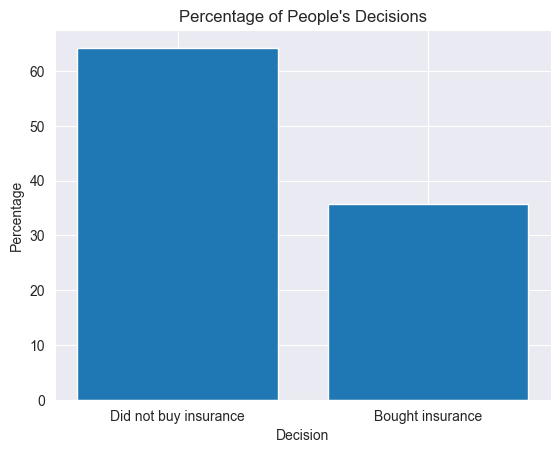

In [148]:
bought = insurance_data["TravelInsurance"].value_counts(normalize=True) * 100
plt.bar(bought.index, bought.values)
plt.xticks([0, 1], ["Did not buy insurance", "Bought insurance"])
plt.xlabel("Decision")
plt.ylabel("Percentage")
plt.title("Percentage of People's Decisions");

The dataset does not have any null values, however the category that we are going to be predicting is not balanced, there's almost twice as many people in one category than there is in the other, therefore, when splitting the dataset we will use the stratify parameter.

In [149]:
x = insurance_data.drop("TravelInsurance", axis=1)
y = insurance_data["TravelInsurance"]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1, stratify=y
)

As the dataset is not too big, around 2000 instances, 20% of our data will be split for the testing set.

In [150]:
x_train_copy = x_train.copy()
x_train_copy.head()

,Age,EmploymentType,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad
673,30,Private Sector/Self Employed,No,750000,3,1,No,No
432,34,Private Sector/Self Employed,Yes,500000,5,0,No,No
1491,26,Private Sector/Self Employed,Yes,1400000,7,1,Yes,Yes
1378,34,Government Sector,Yes,1300000,2,1,No,No
1299,28,Private Sector/Self Employed,Yes,700000,6,1,No,No


In [151]:
categorical_cols = [
    "EmploymentType",
    "GraduateOrNot",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
]
numerical_cols = ["Age", "AnnualIncome", "FamilyMembers"]
for column in categorical_cols:
    unique_values = x_train_copy[column].unique()
    print(f"{column}: {unique_values}")

EmploymentType: ['Private Sector/Self Employed' 'Government Sector']
GraduateOrNot: ['No' 'Yes']
ChronicDiseases: [1 0]
FrequentFlyer: ['No' 'Yes']
EverTravelledAbroad: ['No' 'Yes']


In [152]:
x_train_copy.duplicated().sum()

635

Most of the dataset seems clean, the duplicated function returns quite a few duplicate instances, however considering that there aren't that many features and quite a lot of them are binary it isn't that surprising that there are quite a few rows with the same information.

In [153]:
encoder = LabelEncoder()
for col in categorical_cols:
    x_train_copy[col] = encoder.fit_transform(x_train_copy[col])
x_train_copy.head()

,Age,EmploymentType,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad
673,30,1,0,750000,3,1,0,0
432,34,1,1,500000,5,0,0,0
1491,26,1,1,1400000,7,1,1,1
1378,34,0,1,1300000,2,1,0,0
1299,28,1,1,700000,6,1,0,0


EmploymentType: 0 - Government Sector, 1 - Private Sector/Self Employed
GraduateOrNot: 0 - No, 1 - Yes
ChronicDiseases: 0 - No, 1 - Yes
FrequentFlyer: 0 - No, 1 - Yes
EverTravelledAbroad: 0 - No, 1 - Yes
# Data exploration

In [154]:
x_train_copy.describe()

,Age,EmploymentType,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad
count,1589.000000,1589.000000,1589.000000,1.589000e+03,1589.000000,1589.000000,1589.000000,1589.000000
mean,29.650724,0.711139,0.848332,9.260856e+05,4.727502,0.274386,0.205790,0.189427
std,2.923150,0.453376,0.358811,3.781927e+05,1.601913,0.446345,0.404405,0.391971
min,25.000000,0.000000,0.000000,3.000000e+05,2.000000,0.000000,0.000000,0.000000
25%,28.000000,0.000000,1.000000,6.000000e+05,4.000000,0.000000,0.000000,0.000000
50%,29.000000,1.000000,1.000000,9.000000e+05,4.000000,0.000000,0.000000,0.000000
75%,32.000000,1.000000,1.000000,1.250000e+06,6.000000,1.000000,0.000000,0.000000
max,35.000000,1.000000,1.000000,1.800000e+06,9.000000,1.000000,1.000000,1.000000


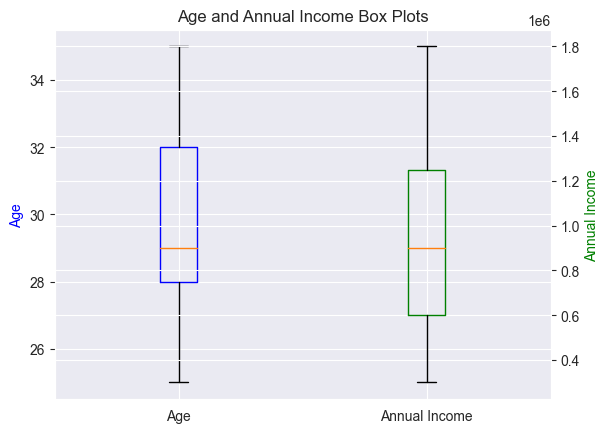

In [155]:
fig, ax1 = plt.subplots()
boxplot_age = ax1.boxplot(
    x_train_copy["Age"], positions=[1], boxprops=dict(color="blue")
)
ax1.set_ylabel("Age", color="blue")
ax2 = ax1.twinx()
boxplot_income = ax2.boxplot(
    x_train_copy["AnnualIncome"], positions=[2], boxprops=dict(color="green")
)
ax2.set_ylabel("Annual Income", color="green")
ax1.set_xticks([1, 2])
ax1.set_xticklabels(["Age", "Annual Income"])
plt.title("Age and Annual Income Box Plots");

Looking at the table, and the graph there doesn't seem to be any outliers present in age, income and family members columns. Max amount of family members, income and age is 9, 1.800.000 and 35. Min amount for same features is 2, 300.000, 25.

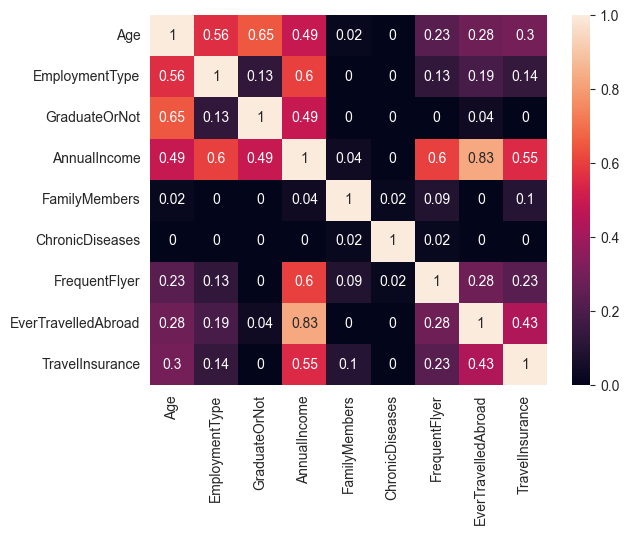

In [156]:
x_joined = x_train_copy.join(y_train)
correlation_matrix = pd.DataFrame(index=x_joined.columns, columns=x_joined.columns)
for col in x_joined.columns:
    for col2 in x_joined.columns:
        if col or col2 not in numerical_cols:
            cm = pd.crosstab(x_joined[col], x_joined[col2])
            correlation = cramers_v(cm)
            correlation_matrix.at[col, col2] = round(correlation, 2)
        else:
            correlation_matrix.at[col, col2] = round(spearmanr(col, col2)[0], 2)
correlation_matrix = correlation_matrix.astype(float)
sns.heatmap(correlation_matrix, annot=True);

We see that quite a few features then to show correlation between each other, which we will have to take care of before building training our models. Also the most impactful features ar most likely to be AnnualIncome and EverTravelledAbroad.

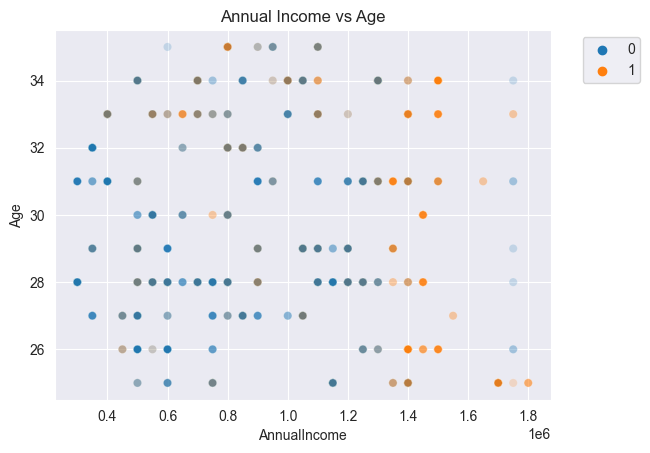

In [157]:
sns.scatterplot(x_train_copy, x="AnnualIncome", y="Age", hue=y_train, alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Annual Income vs Age");

From this scatterplot it is difficult to say much about associations between annual income, age and whether the person has bought insurance or not, other than it seems like people with higher annual income tend to buy it more often.

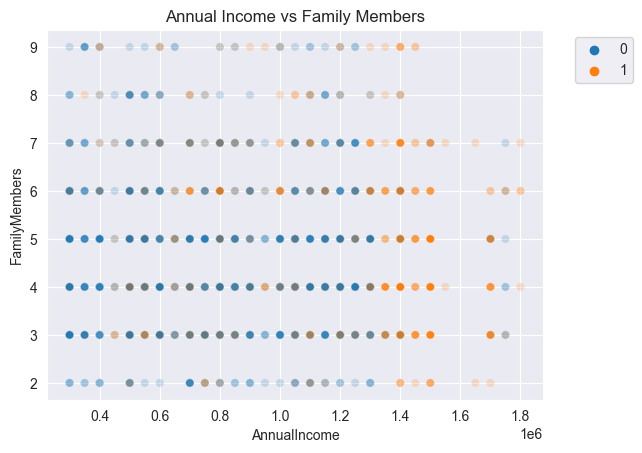

In [158]:
sns.scatterplot(
    x_train_copy, x="AnnualIncome", y="FamilyMembers", hue=y_train, alpha=0.2
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Annual Income vs Family Members");

Same observation as the previous scatterplot, people with higher annual income tend to buy insurance.

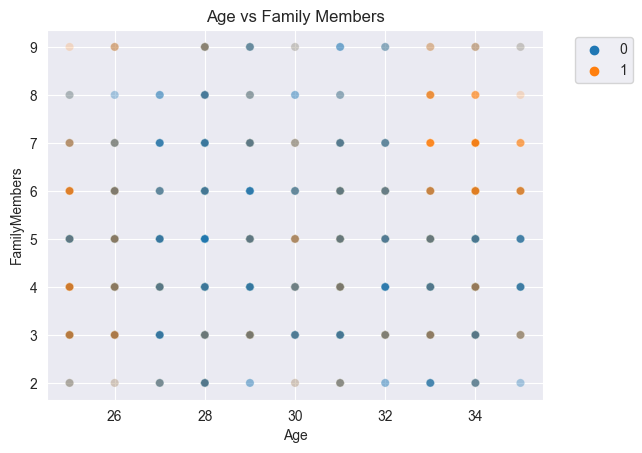

In [159]:
sns.scatterplot(x_train_copy, x="Age", y="FamilyMembers", hue=y_train, alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Age vs Family Members");

Other than older people, with more family members tend to buy insurance more often, there does not seem to be any other tendencies.

In [160]:
fig = px.scatter_3d(
    x_train_copy,
    x="AnnualIncome",
    y="FamilyMembers",
    z="Age",
    color=y_train,
    symbol=y_train,
    opacity=0.2,
    labels={"AnnualIncome": "Annual Income", "Age": "Age"},
    title="Annual Income vs Family Members vs Age",
)
fig.update_layout(
    width=800,
    height=600,
    title=dict(x=0.5, y=0.95, xanchor="center", yanchor="top"),
    coloraxis_colorbar=dict(yanchor="top", y=1, x=1, ticks="outside"),
    legend=dict(x=0.8, y=0.98),
)

Looking at the 3D scatterplot there do seem to be some areas that are denser with people who bought insurance, like, again, people with higher annual income and older people with a lot of family members. We can get the percentages of people who bought and didn't travel insurance by their annual income.

In [161]:
travel_insurance_by_income = (
    x_joined[["AnnualIncome", "TravelInsurance"]]
    .groupby("AnnualIncome")
    .value_counts(normalize=True)
    .reset_index()
)
bought_insurance = travel_insurance_by_income[
    travel_insurance_by_income["TravelInsurance"] == 1
]
did_not_buy_insurance = travel_insurance_by_income[
    travel_insurance_by_income["TravelInsurance"] == 0
]

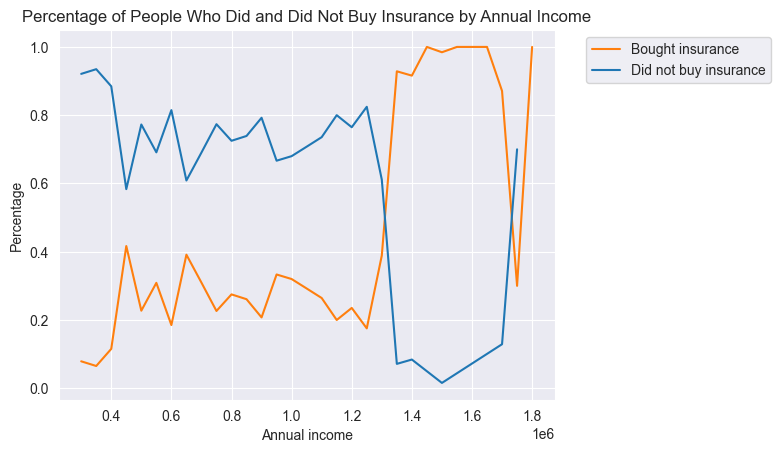

In [162]:
plt.plot(
    bought_insurance["AnnualIncome"],
    bought_insurance["proportion"],
    label="Bought insurance",
    color='C1'
)
plt.plot(
    did_not_buy_insurance["AnnualIncome"],
    did_not_buy_insurance["proportion"],
    label="Did not buy insurance",
    color='C0'
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("Annual income")
plt.ylabel("Percentage")
plt.title("Percentage of People Who Did and Did Not Buy Insurance by Annual Income");

In [163]:
bought_insurance[bought_insurance["proportion"] > 0.5]["AnnualIncome"].min()

1350000

People who have annual income of over 1.35M or more generally tend to buy insurance.

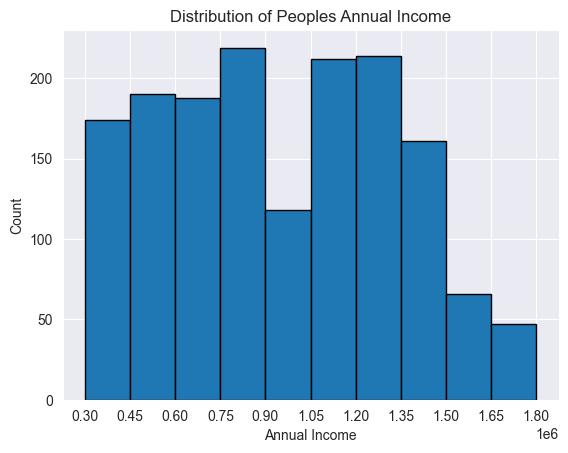

In [164]:
n, bins, edges = plt.hist(x_train_copy["AnnualIncome"], bins=10, ec="black")
plt.xticks(bins)
plt.xlabel("Annual Income")
plt.ylabel("Count")
plt.title("Distribution of Peoples Annual Income");

It is difficult to make any sort of inference about this histogram as it doesn't seem to be majorly skewed, perhaps it is slightly right-skewed and has 2 peaks. We do see however that people with annual income of over 1.35M don't make that big of a part of our training set. Adding a feature that marks whether a person is over a certain annual income threshold might improve the model's performance in the future.

In [165]:
x_train_copy["AnnualIncomeOver1.35M"] = np.where(
    x_train_copy["AnnualIncome"] >= 1350000, 1, 0
)

We should also check other numerical features hold any similar information, where certain groups of people have a higher chance to buy or not to buy insurance.

In [166]:
travel_insurance_by_age = (
    x_joined[["Age", "TravelInsurance"]]
    .groupby("Age")
    .value_counts(normalize=True)
    .reset_index()
)
age_bought_insurance = travel_insurance_by_age[
    travel_insurance_by_age["TravelInsurance"] == 1
]
age_did_not_buy_insurance = travel_insurance_by_age[
    travel_insurance_by_age["TravelInsurance"] == 0
]

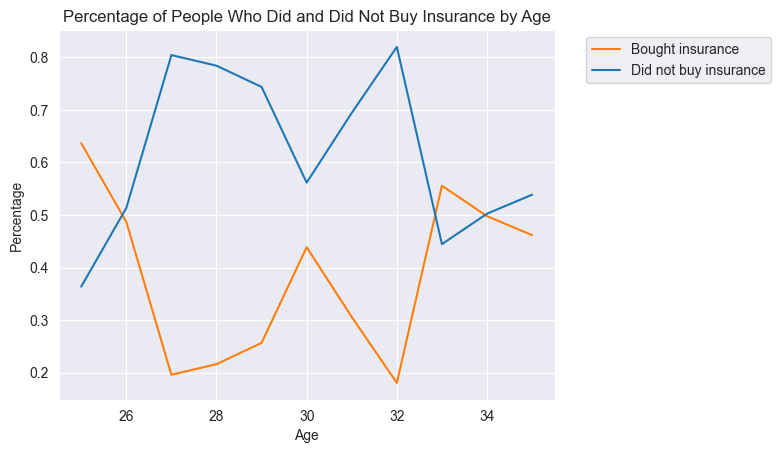

In [167]:
plt.plot(
    age_bought_insurance["Age"],
    age_bought_insurance["proportion"],
    label="Bought insurance",
    color='C1',
)
plt.plot(
    age_did_not_buy_insurance["Age"],
    age_did_not_buy_insurance["proportion"],
    label="Did not buy insurance",
    color='C0',
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("Age")
plt.ylabel("Percentage")
plt.title("Percentage of People Who Did and Did Not Buy Insurance by Age");

When it comes to age we can only say that people of ages 27, 28, 29, 31 and 32 have a significantly higher rate of not buying insurance, however I can not think of a reason why these specific ages tend not to buy insurance at a significantly higher rate.

In [168]:
travel_insurance_by_family = (
    x_joined[["FamilyMembers", "TravelInsurance"]]
    .groupby("FamilyMembers")
    .value_counts(normalize=True)
    .reset_index()
)
family_bought_insurance = travel_insurance_by_family[
    travel_insurance_by_family["TravelInsurance"] == 1
]
family_did_not_buy_insurance = travel_insurance_by_family[
    travel_insurance_by_family["TravelInsurance"] == 0
]

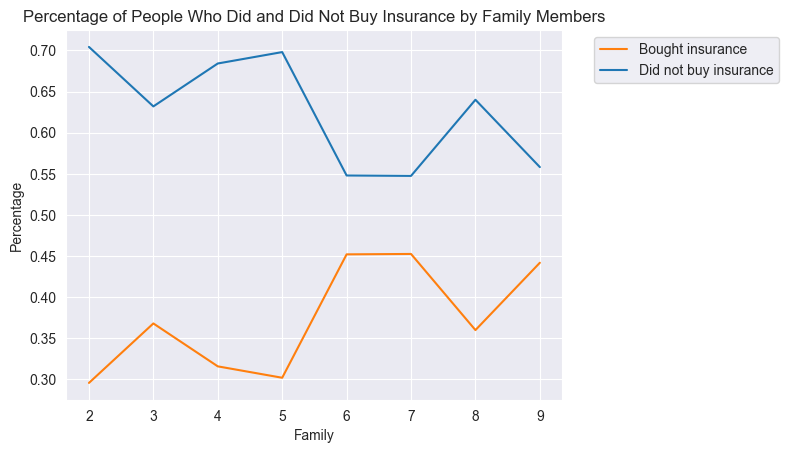

In [169]:
plt.plot(
    family_bought_insurance["FamilyMembers"],
    family_bought_insurance["proportion"],
    label="Bought insurance",
    color='C1',
)
plt.plot(
    family_did_not_buy_insurance["FamilyMembers"],
    family_did_not_buy_insurance["proportion"],
    label="Did not buy insurance",
    color='C0'
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("Family")
plt.ylabel("Percentage")
plt.title("Percentage of People Who Did and Did Not Buy Insurance by Family Members");

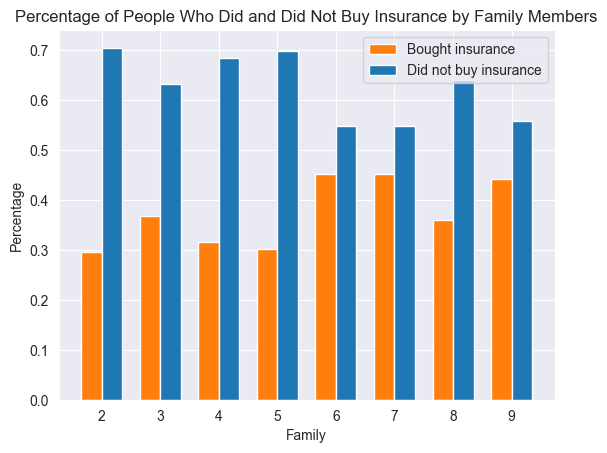

In [170]:
# Set the width of the bars
bar_width = 0.35

# Generate x-coordinates for each group
x_bought = np.arange(len(family_bought_insurance["FamilyMembers"]))
x_not_bought = np.arange(len(family_did_not_buy_insurance["FamilyMembers"])) + bar_width

# Plot the bars for "Bought insurance"
plt.bar(
    x_bought,
    family_bought_insurance["proportion"],
    width=bar_width,
    label="Bought insurance",
    color='C1',
)

# Plot the bars for "Did not buy insurance"
plt.bar(
    x_not_bought,
    family_did_not_buy_insurance["proportion"],
    width=bar_width,
    label="Did not buy insurance",
    color='C0',
)

# Set x-axis ticks and labels
plt.xticks(x_bought + bar_width / 2, family_bought_insurance["FamilyMembers"])

plt.legend()
plt.xlabel("Family")
plt.ylabel("Percentage")
plt.title("Percentage of People Who Did and Did Not Buy Insurance by Family Members");

And when looking at family members feature, it does not seem like at any point do people with certain amount of family members get insurance more often than not.

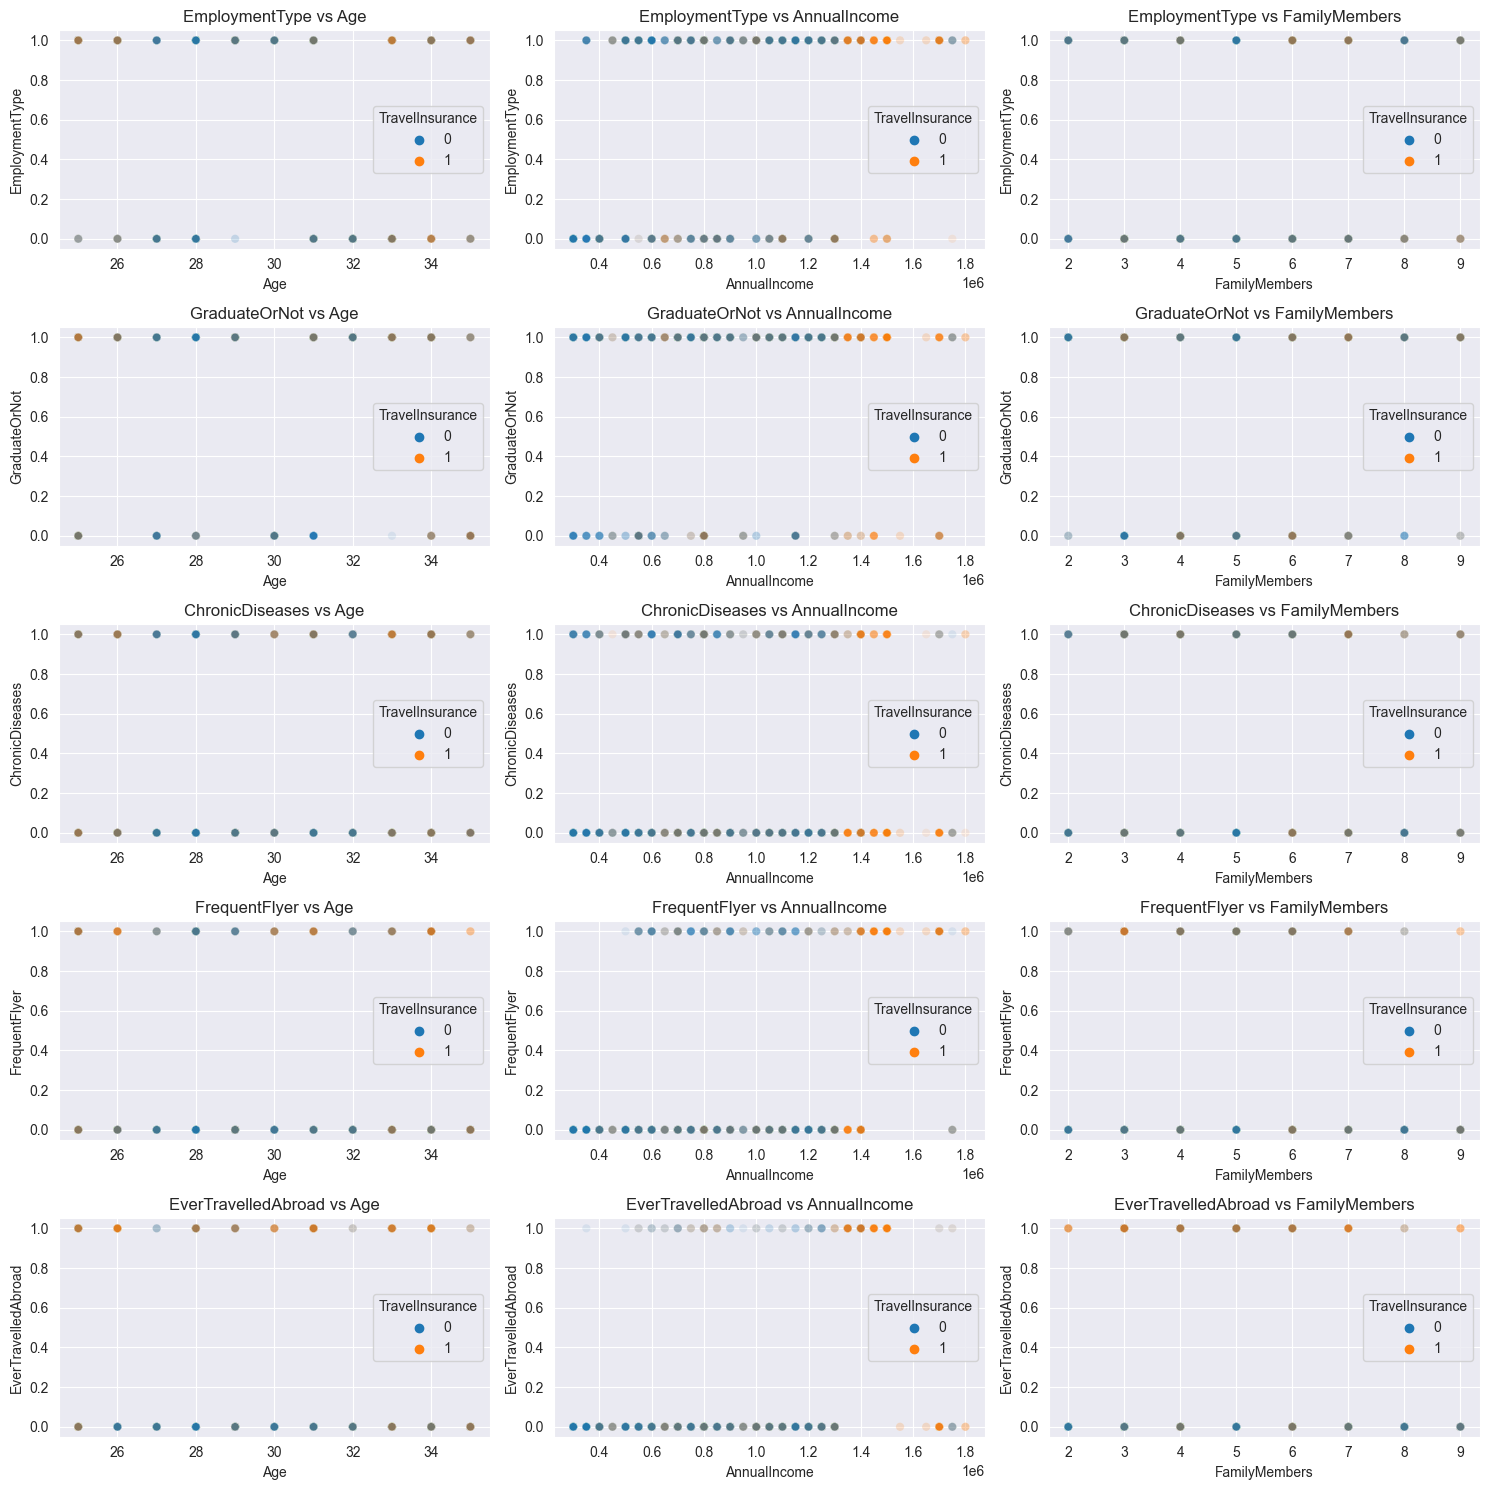

In [171]:
fig, axes = plt.subplots(len(categorical_cols), len(numerical_cols), figsize=(15, 15))
for i, cat_feature in enumerate(categorical_cols):
    for j, num_feature in enumerate(numerical_cols):
        sns.scatterplot(
            ax=axes[i, j],
            data=x_train_copy,
            x=num_feature,
            y=cat_feature,
            hue=y_train,
            alpha=0.1,
        )
        axes[i, j].set_title(f"{cat_feature} vs {num_feature}")
plt.tight_layout()

Looking at the plots of binary variables, none of them seem to separate the points all that well, except for perhaps the EverTravelledAbroad feature, since it's a bit difficult to get an accurate understanding of how many points we're separating, we can print out the table itself.

In [172]:
x_joined[["EverTravelledAbroad", "TravelInsurance"]].value_counts()

EverTravelledAbroad  TravelInsurance
0                    0                  956
                     1                  332
1                    1                  236
                     0                   65
Name: count, dtype: int64

Seems like it does separate part of the features relatively well, we have around 20% people who have bought travel insurance and 80% who have bought travel insurance among people who have travelled abroad before. Similarly, we can check how well combinations of features tend to separate the categories. It doesn't make much sense to plot them on a graph as we would have 4 points in total only with a bunch of overlap, we can instead present a table.

In [173]:
x_joined.groupby(["FrequentFlyer", "EverTravelledAbroad"])[
    "TravelInsurance"
].value_counts()

FrequentFlyer  EverTravelledAbroad  TravelInsurance
0              0                    0                  832
                                    1                  261
               1                    1                  119
                                    0                   50
1              0                    0                  124
                                    1                   71
               1                    1                  117
                                    0                   15
Name: count, dtype: int64

From this table we can see that people who do not frequently travel and have not ever travelled abroad tend to not get travelling insurance. We could combine the information from both of these features to make another binary feature whether a person to emphasise this information more.

In [174]:
x_train_copy["NotATraveller"] = np.where(
    (x_train_copy["FrequentFlyer"] == 0) & (x_train_copy["EverTravelledAbroad"] == 0),
    1,
    0,
)

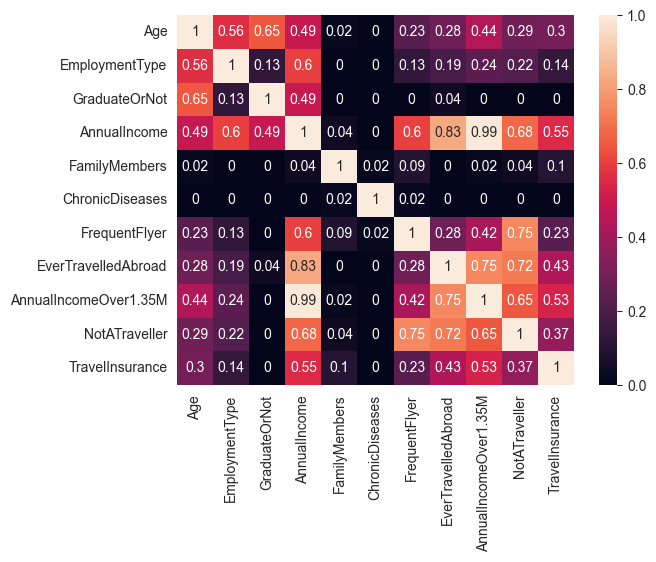

In [175]:
x_joined = x_train_copy.join(y_train)
correlation_matrix = pd.DataFrame(index=x_joined.columns,
                                  columns=x_joined.columns)
for col in x_joined.columns:
    for col2 in x_joined.columns:
        if col or col2 not in numerical_cols:
            cm = pd.crosstab(x_joined[col], x_joined[col2])
            correlation = cramers_v(cm)
            correlation_matrix.at[col, col2] = round(correlation, 2)
        else:
            correlation_matrix.at[col, col2] = round(spearmanr(col, col2)[0],
                                                     2)
correlation_matrix = correlation_matrix.astype(float)
sns.heatmap(correlation_matrix, annot=True);

Bringing back the heatmap of a correlation matrix, we can see that we've possibly introduced some more multi-collinearity, now whether it's something we should be worried about we're going to check with variance inflation factor metric. We'll only calculate it for features that could have some relevant impact on the dependant feature.

In [177]:
independent_variables = x_joined[
    [
        "Age",
        "AnnualIncome",
        "FrequentFlyer",
        "EverTravelledAbroad",
        "AnnualIncomeOver1.35M",
        "NotATraveller",
    ]
]

vif_data = pd.DataFrame()
vif_data["Variable"] = independent_variables.columns
vif_data["VIF"] = [
    variance_inflation_factor(independent_variables.values, i)
    for i in range(independent_variables.shape[1])
]
vif_data

,Variable,VIF
0,Age,34.529229
1,AnnualIncome,12.399722
2,FrequentFlyer,4.335242
3,EverTravelledAbroad,5.555742
4,AnnualIncomeOver1.35M,4.233736
5,NotATraveller,19.068078


We have 4 variables that have VIF over 5, age, annual income and not a traveller feature that we made earlier. We're going to remove the age feature. Even though annual income feature has higher vif score, I believe that it also has more depth and has more to offer when it comes to predictions, so we'll be removing the NotATraveller feature.

In [178]:
columns_to_leave = [
    "AnnualIncome",
    "FrequentFlyer",
    "EverTravelledAbroad",
    "AnnualIncomeOver1.35M",
]
independent_variables = x_joined[columns_to_leave]

vif_data = pd.DataFrame()
vif_data["Variable"] = independent_variables.columns
vif_data["VIF"] = [
    variance_inflation_factor(independent_variables.values, i)
    for i in range(independent_variables.shape[1])
]
vif_data

,Variable,VIF
0,AnnualIncome,1.849831
1,FrequentFlyer,1.552370
2,EverTravelledAbroad,2.837247
3,AnnualIncomeOver1.35M,3.276435


# Statistical inference
In this section we will be conducting statistical tests for whether there's any significant association between our variables. One of the tests we can use for that is Chi-square test between two categorical variables, so between our dependant variable and other categorical independent variables. To set up the tests we will define a few things:
* The **significance level** for out test will be **0.05**;
* The **null hypothesis** states that there is no association between the categorical variables.
* The **alternative hypothesis** states that there is association between the categorical variables

In [59]:
columns_to_test = [
    "EmploymentType",
    "GraduateOrNot",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
    "AnnualIncomeOver1.35M",
    "NotATraveller",
]
for cat_col in columns_to_test:
    contingency_table = pd.crosstab(x_train_copy[cat_col], y_train)
    _, p, _, _ = chi2_contingency(contingency_table)
    if p < 0.05:
        print(
            f"P-Value ({p}) is less than 0.05 for feature {cat_col}, reject the null hypothesis"
        )
    if p > 0.05:
        print(
            f"P-Value ({p}) is more than 0.05 for feature {cat_col}, fail to reject the null hypothesis"
        )

P-Value (5.195225218448131e-09) is less than 0.05 for feature EmploymentType, reject the null hypothesis
P-Value (0.8100314759083219) is more than 0.05 for feature GraduateOrNot, fail to reject the null hypothesis
P-Value (0.5075630863745488) is more than 0.05 for feature ChronicDiseases, fail to reject the null hypothesis
P-Value (6.096499444711552e-20) is less than 0.05 for feature FrequentFlyer, reject the null hypothesis
P-Value (1.879541094902527e-65) is less than 0.05 for feature EverTravelledAbroad, reject the null hypothesis
P-Value (3.4576005050604507e-99) is less than 0.05 for feature AnnualIncomeOver1.35M, reject the null hypothesis
P-Value (3.0074222980926845e-48) is less than 0.05 for feature NotATraveller, reject the null hypothesis


Out of all the categorical variables we cannot confirm that there is association only for two variables, GraduateOrNot and ChronicDiseases features, therefore we most likely shouldn't use them.

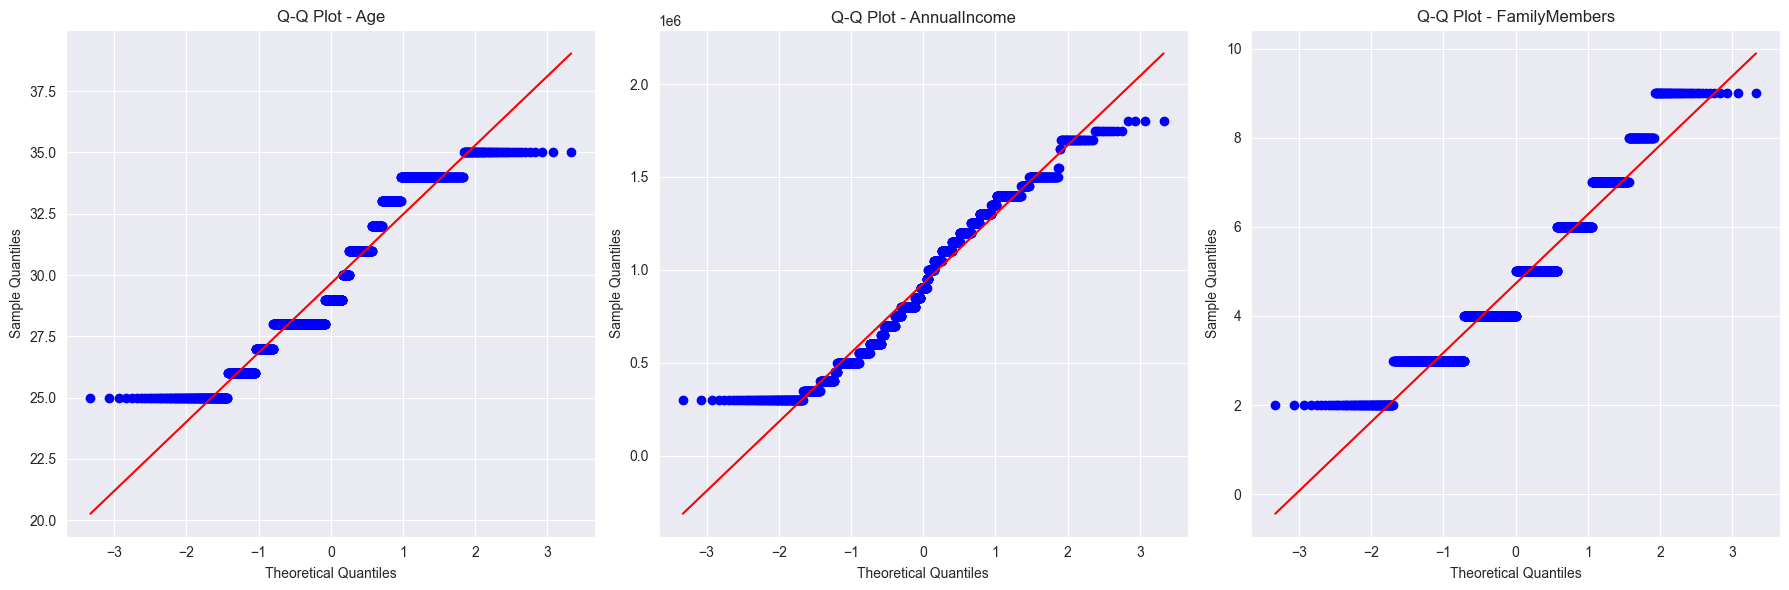

In [60]:
columns_to_test = ["Age", "AnnualIncome", "FamilyMembers"]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for index, num_col in enumerate(columns_to_test):
    probplot(x_train_copy[num_col], plot=axs[index], fit=True)
    axs[index].set_title(f"Q-Q Plot - {num_col}")
    axs[index].set_xlabel("Theoretical Quantiles")
    axs[index].set_ylabel("Sample Quantiles")

plt.tight_layout()

Neither of these variables are normally distributed, therefore we'll need to use non-parametric tests, like Mann-Whitney U or Kruskal-Wallis H. To set up the tests we will be using the same parameters:
* The **significance level** for out test will be **0.05**;
* The **null hypothesis** states that there is no significant difference in the distributions of the numerical variable between the two categories.
* The **alternative hypothesis** states that there is a significant difference in the distributions.

In [61]:
for num_col in columns_to_test:
    stat, p = mannwhitneyu(x_train_copy[num_col], y_train)
    if p < 0.05:
        print(
            f"P-Value ({p}) is less than 0.05 for feature {num_col}, reject the null hypothesis"
        )
    if p > 0.05:
        print(
            f"P-Value ({p}) is more than 0.05 for feature {num_col}, fail to reject the null hypothesis"
        )

P-Value (0.0) is less than 0.05 for feature Age, reject the null hypothesis
P-Value (0.0) is less than 0.05 for feature AnnualIncome, reject the null hypothesis
P-Value (0.0) is less than 0.05 for feature FamilyMembers, reject the null hypothesis


Rejecting the null hypotheses means that there is a significant difference between the groups who have bought insurance and didn't buy insurance, therefore we should be able and if need be use these features to train machine learning models. While the test does not state how good they are for our goals, we can say that it does separate the groups to some extent.
# Machine learning
In this part we'll be training several machine learning models and in the end trying to combine them into a single ensemble model. The process will follow few general steps:
* Transformation of the training set;
* Training of the model;
* Investigation of the predictions and metrics;
* Search for optimal hyperparameters;
* Cross validation of the model.

First we'll create the transformers for data transformation, and then we'll try out SVC with 2 different kernels, logistic regression classifier, decision trees algorithm, random forests and voting classifier.

In [62]:
label_encoder = LabelEncoder()
annual_income_feature = AnnualIncomeCreator()
column_selector = ColumnSelector(
    columns=[
        "AnnualIncome",
        "FrequentFlyer",
        "EverTravelledAbroad",
        "AnnualIncomeOver1.35M",
    ]
)
standard_scaler = StandardScaler()
pca = PCA(n_components=2)

In [63]:
x_train["EverTravelledAbroad"] = label_encoder.fit_transform(
    x_train["EverTravelledAbroad"]
)
x_train["FrequentFlyer"] = label_encoder.fit_transform(x_train["FrequentFlyer"])
x_train_transformed = annual_income_feature.fit_transform(x_train)
to_scale = np.asarray(x_train["AnnualIncome"])
to_scale = to_scale.reshape(-1, 1)
scaled = standard_scaler.fit_transform(to_scale)
x_train_transformed["AnnualIncome"] = scaled
x_train_transformed = column_selector.fit_transform(x_train_transformed)
x_train_transformed = pca.fit_transform(x_train_transformed)

We encode the labels, create an extra feature, select the columns that we're going to be working with, scale the annual income column and reduce the amount of features down to two.
## SVC(kernel='linear')

              precision    recall  f1-score   support

           0       0.76      0.81      0.79      1021
           1       0.62      0.54      0.58       568

    accuracy                           0.72      1589
   macro avg       0.69      0.68      0.68      1589
weighted avg       0.71      0.72      0.71      1589



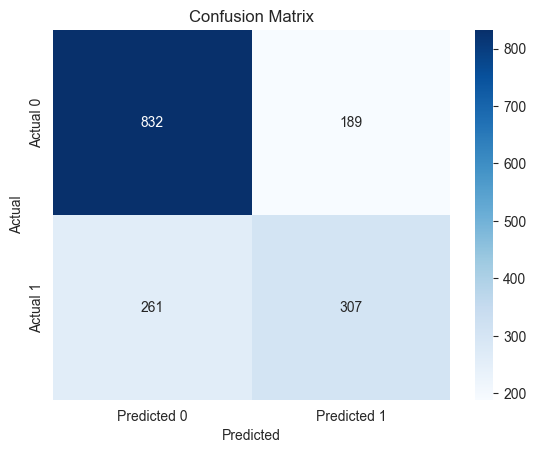

In [64]:
linear_svc_model = SVC(kernel="linear", probability=True, random_state=1)
linear_svc_model.fit(x_train_transformed, y_train)
linear_svc_predictions = linear_svc_model.predict(x_train_transformed)
linear_svc_cm = confusion_matrix(y_train, linear_svc_predictions)
linear_svc_report = classification_report(y_train, linear_svc_predictions)
sns.heatmap(
    linear_svc_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(linear_svc_report)

This is our baseline model, we see that it gets quite a few predictions correct, however it does miss-classify quite a few true negatives (people who have actually bought the insurance) as if they haven't. It makes type 2 error quite often. Usually making a type 1 error would be worse, but I believe that in this case it is the opposite, as we are losing out on potential profits. Since the dataset is quite imbalanced, we can try to balance it by setting different class weights.

              precision    recall  f1-score   support

           0       0.76      0.81      0.79      1021
           1       0.62      0.54      0.58       568

    accuracy                           0.72      1589
   macro avg       0.69      0.68      0.68      1589
weighted avg       0.71      0.72      0.71      1589



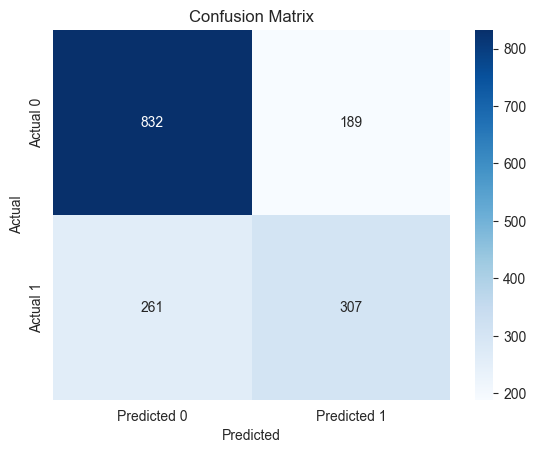

In [65]:
linear_svc_model = SVC(
    kernel="linear", probability=True, class_weight="balanced", random_state=1
)
linear_svc_model.fit(x_train_transformed, y_train)
linear_svc_predictions = linear_svc_model.predict(x_train_transformed)
linear_svc_cm = confusion_matrix(y_train, linear_svc_predictions)
linear_svc_report = classification_report(y_train, linear_svc_predictions)
sns.heatmap(
    linear_svc_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(linear_svc_report)

Balanced class weights did not seem to do much for the model's predictions. Perhaps setting more aggressive weights would have more impact.

SVC(C=0.1, class_weight='balanced', kernel='linear', probability=True,
    random_state=1)
              precision    recall  f1-score   support

           0       0.76      0.81      0.79      1021
           1       0.62      0.54      0.58       568

    accuracy                           0.72      1589
   macro avg       0.69      0.68      0.68      1589
weighted avg       0.71      0.72      0.71      1589



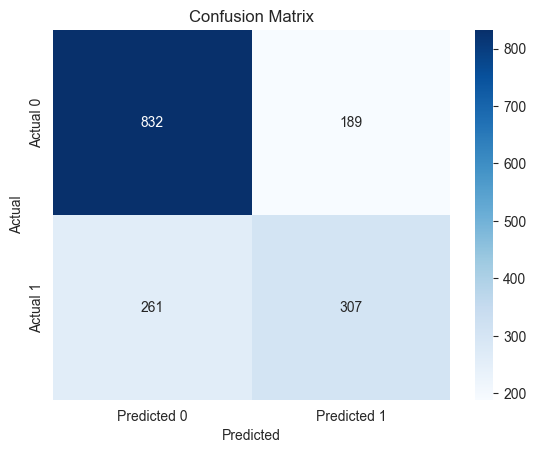

In [66]:
param_grid = {"C": [0.1, 0.25, 0.5, 0.75, 1, 10, 100]}
grid_search = GridSearchCV(
    estimator=linear_svc_model, param_grid=param_grid, cv=5, scoring="recall"
)
grid_search.fit(x_train_transformed, y_train)
best_linear_svc_model = grid_search.best_estimator_
linear_svc_predictions = best_linear_svc_model.predict(x_train_transformed)
linear_svc_cm = confusion_matrix(y_train, linear_svc_predictions)
sns.heatmap(
    linear_svc_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(best_linear_svc_model)
print(classification_report(y_train, linear_svc_predictions))

Seems like we have found the optimal hyperparameters, however using them hasn't improved any of the metrics.

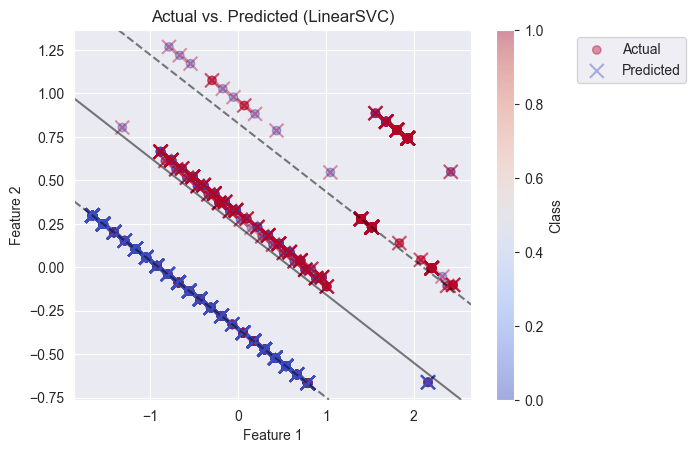

In [67]:
scatter_actual = plt.scatter(
    x_train_transformed[:, 0],
    x_train_transformed[:, 1],
    c=y_train,
    marker="o",
    label="Actual",
    cmap="coolwarm",
    alpha=0.4,
)
scatter_predicted = plt.scatter(
    x_train_transformed[:, 0],
    x_train_transformed[:, 1],
    c=linear_svc_predictions,
    marker="x",
    label="Predicted",
    cmap="coolwarm",
    alpha=0.4,
    s=100,
)

cbar_actual = plt.colorbar(scatter_actual)
cbar_actual.set_label("Class")

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
)
Z = best_linear_svc_model.decision_function(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contour(
    xx, yy, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)

plt.title("Actual vs. Predicted (LinearSVC)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(bbox_to_anchor=(1.25, 1), loc="upper left");

In the plot we can see the predictions vs the actual values, red dots represent instances of bought insurance, while blue dots represent instances of didn't buy insurance, while red crosses represent the predictions of bought insurance and blue crosses, didn't buy insurnace. We can see the decision boundary, where to the right of it model starts predicting that those instances are of people who bought insurance and to the left of it, predictions become that they didn't buy the insurance.

In [68]:
num_folds = 5
cv = KFold(n_splits=num_folds, shuffle=True, random_state=1)
scores = cross_val_score(
    best_linear_svc_model, x_train_transformed, y_train, cv=cv, scoring="recall"
)
for fold, recall in enumerate(scores, start=1):
    print(f"Fold {fold}: Recall = {recall:.2f}")

print(f"\nMean Recall: {np.mean(scores):.2f}")
print(f"Standard Deviation: {np.std(scores):.2f}")

Fold 1: Recall = 0.51
Fold 2: Recall = 0.51
Fold 3: Recall = 0.55
Fold 4: Recall = 0.56
Fold 5: Recall = 0.56

Mean Recall: 0.54
Standard Deviation: 0.02


After cross validation we see that we get average recall of 0.54, with a standard deviation of 0.02. The next model we're going to train is going to be an SVC with the rbf kernel.
## SVC(kernel='rbf')

              precision    recall  f1-score   support

           0       0.76      0.98      0.86      1021
           1       0.93      0.44      0.60       568

    accuracy                           0.79      1589
   macro avg       0.84      0.71      0.73      1589
weighted avg       0.82      0.79      0.76      1589



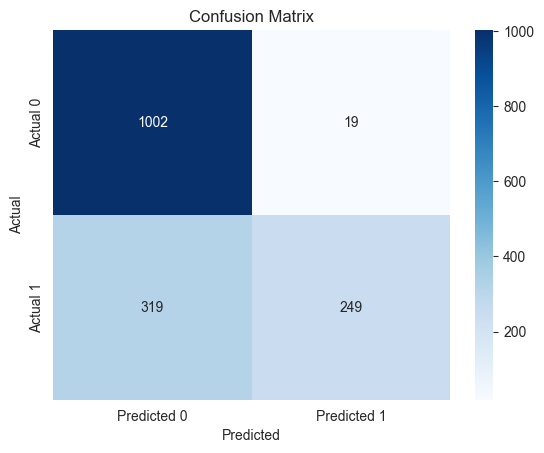

In [69]:
rbf_svc_model = SVC(
    kernel="rbf", probability=True, random_state=1, class_weight="balanced"
)
rbf_svc_model.fit(x_train_transformed, y_train)
rbf_svc_predictions = rbf_svc_model.predict(x_train_transformed)
rbf_svc_cm = confusion_matrix(y_train, rbf_svc_predictions)
rbf_svc_report = classification_report(y_train, rbf_svc_predictions)
sns.heatmap(
    rbf_svc_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(rbf_svc_report)

While precision has greatly improved, the downside of it is that the recall of our class that matters most to us has decreased. We're back to making a lot of type 2 errors, which we could probably fix by assigning the "1" class a higher weight.

SVC(C=100, class_weight='balanced', gamma=100, probability=True, random_state=1)
              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1021
           1       0.83      0.51      0.63       568

    accuracy                           0.79      1589
   macro avg       0.80      0.72      0.74      1589
weighted avg       0.80      0.79      0.77      1589



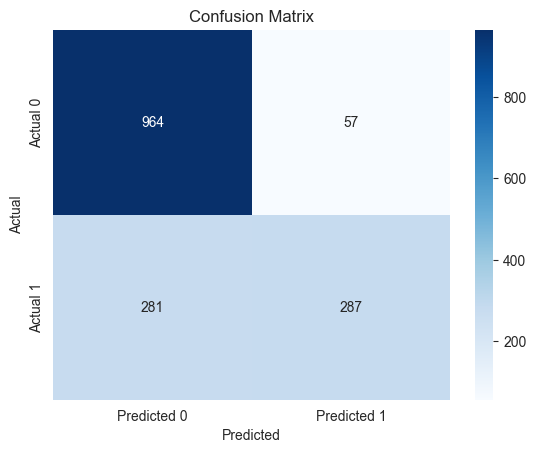

In [70]:
param_grid = {"C": [0.1, 1, 10, 100], "gamma": [0.1, 1, 10, 100]}
grid_search = GridSearchCV(
    estimator=rbf_svc_model, param_grid=param_grid, cv=5, scoring="recall"
)
grid_search.fit(x_train_transformed, y_train)
best_rbf_svc_model = grid_search.best_estimator_
rbf_svc_predictions = best_rbf_svc_model.predict(x_train_transformed)
rbf_svc_cm = confusion_matrix(y_train, rbf_svc_predictions)
sns.heatmap(
    rbf_svc_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(best_rbf_svc_model)
print(classification_report(y_train, rbf_svc_predictions))

After tuning the hyperparameters, we have more balanced recall at the cost of precision.

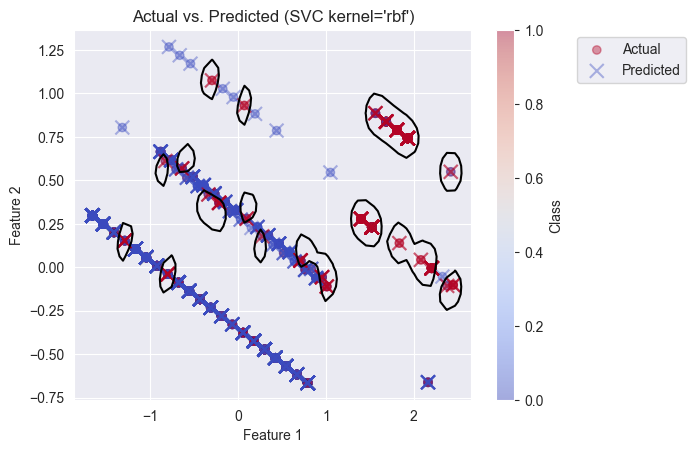

In [71]:
scatter_actual = plt.scatter(
    x_train_transformed[:, 0],
    x_train_transformed[:, 1],
    c=y_train,
    marker="o",
    label="Actual",
    cmap="coolwarm",
    alpha=0.4,
)
scatter_predicted = plt.scatter(
    x_train_transformed[:, 0],
    x_train_transformed[:, 1],
    c=rbf_svc_predictions,
    marker="x",
    label="Predicted",
    cmap="coolwarm",
    alpha=0.4,
    s=100,
)

cbar_actual = plt.colorbar(scatter_actual)
cbar_actual.set_label("Class")

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
)
Z = best_rbf_svc_model.decision_function(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors="k", levels=0, alpha=1, linestyles="-")

plt.title("Actual vs. Predicted (SVC kernel='rbf')")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(bbox_to_anchor=(1.25, 1), loc="upper left");

We see the way that rbf kernel influences the selection of which points the model predicts as class 1.

In [72]:
num_folds = 5
cv = KFold(n_splits=num_folds, shuffle=True, random_state=1)
scores = cross_val_score(
    best_rbf_svc_model, x_train_transformed, y_train, cv=cv, scoring="recall"
)
for fold, recall in enumerate(scores, start=1):
    print(f"Fold {fold}: Recall = {recall:.2f}")

print(f"\nMean Recall: {np.mean(scores):.2f}")
print(f"Standard Deviation: {np.std(scores):.2f}")

Fold 1: Recall = 0.50
Fold 2: Recall = 0.51
Fold 3: Recall = 0.52
Fold 4: Recall = 0.54
Fold 5: Recall = 0.46

Mean Recall: 0.51
Standard Deviation: 0.03


In the end, recall wise we end up with very similar model, with average recall of 0.51 and standard dveiation of 0.03. Moving on we'll train a logistic regression model.
## Logistic Regression

              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1021
           1       0.64      0.53      0.58       568

    accuracy                           0.73      1589
   macro avg       0.70      0.68      0.69      1589
weighted avg       0.72      0.73      0.72      1589



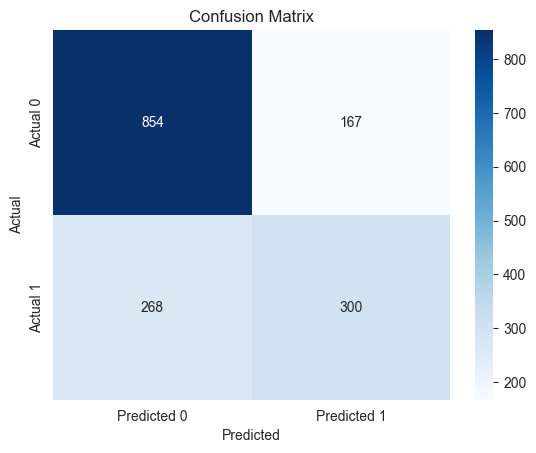

In [73]:
logreg_model = LogisticRegression(random_state=1, class_weight="balanced")
logreg_model.fit(x_train_transformed, y_train)
logreg_predictions = logreg_model.predict(x_train_transformed)
logreg_cm = confusion_matrix(y_train, logreg_predictions)
logreg_report = classification_report(y_train, logreg_predictions)
sns.heatmap(
    logreg_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(logreg_report)

With logistic regression model we get even higher recall for '1' class, as a result precision and recall suffer slightly.

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1', random_state=1,
                   solver='liblinear')
              precision    recall  f1-score   support

           0       0.77      0.80      0.78      1021
           1       0.61      0.56      0.59       568

    accuracy                           0.72      1589
   macro avg       0.69      0.68      0.68      1589
weighted avg       0.71      0.72      0.71      1589



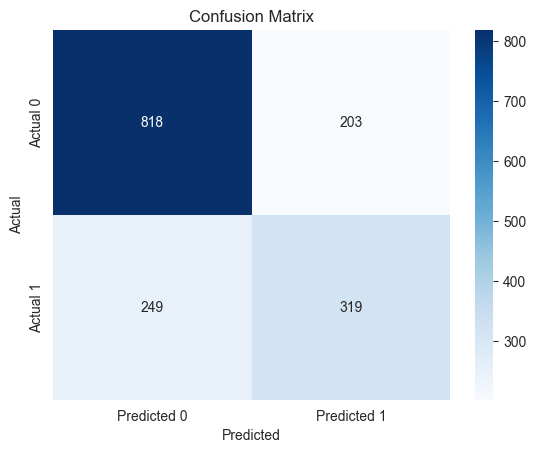

In [74]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)
param_grid = {
    "solver": ["liblinear", "newton-cg", "lbfgs", "sag", "saga"],
    "penalty": ["l1", "l2", "elasticnet"],
    "C": [0.1, 0.5, 1, 5, 10, 100],
}
grid_search = GridSearchCV(
    estimator=logreg_model, param_grid=param_grid, cv=5, scoring="recall"
)
grid_search.fit(x_train_transformed, y_train)
best_logreg_model = grid_search.best_estimator_
logreg_predictions = best_logreg_model.predict(x_train_transformed)
logreg_cm = confusion_matrix(y_train, logreg_predictions)
sns.heatmap(
    logreg_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(best_logreg_model)
print(classification_report(y_train, logreg_predictions))
warnings.filterwarnings("default", category=UserWarning)
warnings.filterwarnings("default", category=FitFailedWarning)

Some of the combinations of hyperparameters are impossible, thus we've suppressed the warnings for this cell. Hyperparameter tuning has helped slightly with classification of '1' class, once again at the cost of precision, and other parameters of class '0'.

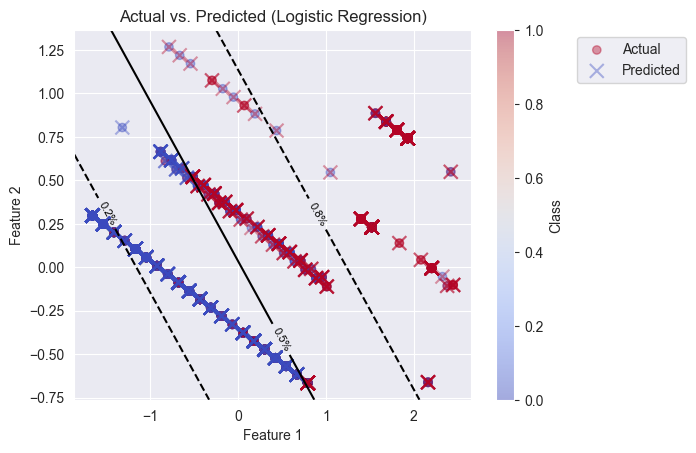

In [75]:
scatter_actual = plt.scatter(
    x_train_transformed[:, 0],
    x_train_transformed[:, 1],
    c=y_train,
    marker="o",
    label="Actual",
    cmap="coolwarm",
    alpha=0.4,
)
scatter_predicted = plt.scatter(
    x_train_transformed[:, 0],
    x_train_transformed[:, 1],
    c=logreg_predictions,
    marker="x",
    label="Predicted",
    cmap="coolwarm",
    alpha=0.4,
    s=100,
)
cbar_actual = plt.colorbar(scatter_actual)
cbar_actual.set_label("Class")

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
)
Z = best_logreg_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
probabilities = 1 / (1 + np.exp(-Z))
contour_lines = plt.contour(
    xx,
    yy,
    probabilities,
    levels=[0.25, 0.5, 0.75],
    colors="k",
    alpha=1,
    linestyles=["--", "-", "--"],
)

plt.clabel(contour_lines, inline=True, fontsize=8, colors="k", fmt="%1.1f%%")
plt.title("Actual vs. Predicted (Logistic Regression)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(bbox_to_anchor=(1.25, 1), loc="upper left");

Since logistic regression decision-making is probabilistic, we can plot the decision boundary at which being in either class has probability of 50%. Generally everything left of it will be classified as '0' and right of it as '1'. What differs is how sure the model is of its prediction. The further away a point is from the decision boundary, the higher the probability of an instance being of the predicted class, according to the model.

In [76]:
num_folds = 5
cv = KFold(n_splits=num_folds, shuffle=True, random_state=1)
scores = cross_val_score(
    best_logreg_model, x_train_transformed, y_train, cv=cv, scoring="recall"
)
for fold, recall in enumerate(scores, start=1):
    print(f"Fold {fold}: Recall = {recall:.2f}")

print(f"\nMean Recall: {np.mean(scores):.2f}")
print(f"Standard Deviation: {np.std(scores):.2f}")

Fold 1: Recall = 0.53
Fold 2: Recall = 0.50
Fold 3: Recall = 0.59
Fold 4: Recall = 0.60
Fold 5: Recall = 0.62

Mean Recall: 0.57
Standard Deviation: 0.04


Using cross validation, currently this is arguably our best performing model so far with the average recall of 0.57, and standard deviation of 0.04.
## Decision Trees

              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1021
           1       0.83      0.51      0.63       568

    accuracy                           0.79      1589
   macro avg       0.80      0.72      0.74      1589
weighted avg       0.80      0.79      0.77      1589



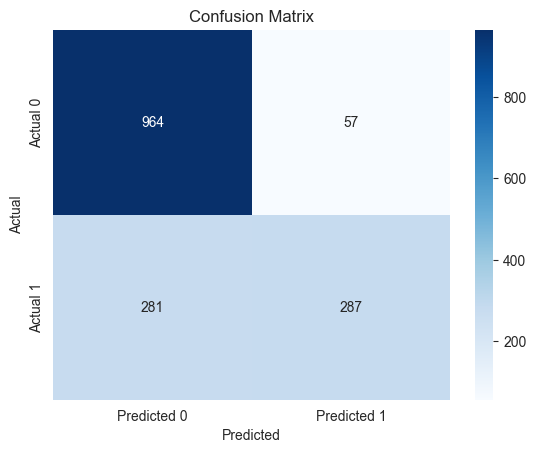

In [77]:
decision_tree_model = DecisionTreeClassifier(random_state=1, class_weight="balanced")
decision_tree_model.fit(x_train_transformed, y_train)
decision_tree_predictions = decision_tree_model.predict(x_train_transformed)
decision_tree_cm = confusion_matrix(y_train, decision_tree_predictions)
decision_tree_report = classification_report(y_train, decision_tree_predictions)
sns.heatmap(
    decision_tree_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(decision_tree_report)

Generally if decision trees are left unchecked, like here they are very prone to over-fitting. Considering what we have seen from previous plots, it shouldn't come as a surprise that even decision trees are unable to get perfect accuracy as quite a lot of points from our classes are overlapping, this shows that the data that we have selected is not good enough to separate certain points.

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       max_features='sqrt', min_samples_leaf=20,
                       random_state=1)
              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1021
           1       0.88      0.46      0.60       568

    accuracy                           0.78      1589
   macro avg       0.82      0.71      0.73      1589
weighted avg       0.80      0.78      0.76      1589



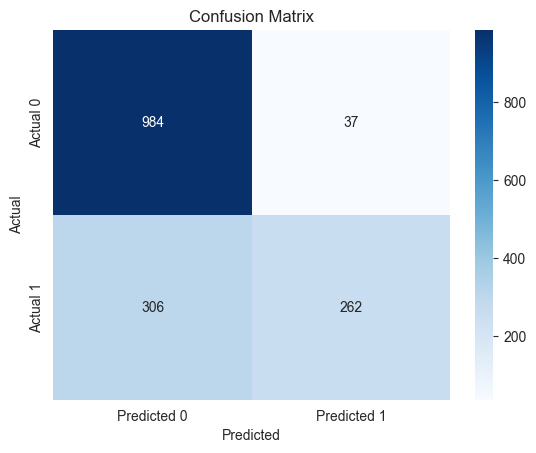

In [78]:
param_grid = {
    "max_depth": [4],
    "min_samples_leaf": [5, 10, 20, 50],
    "max_features": ["sqrt", "log2"],
}
grid_search = GridSearchCV(
    estimator=decision_tree_model, param_grid=param_grid, cv=5, scoring="recall"
)
grid_search.fit(x_train_transformed, y_train)
best_decision_tree_model = grid_search.best_estimator_
decision_tree_predictions = best_decision_tree_model.predict(x_train_transformed)
decision_tree_cm = confusion_matrix(y_train, decision_tree_predictions)
sns.heatmap(
    decision_tree_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(best_decision_tree_model)
print(classification_report(y_train, decision_tree_predictions))

During hyperparameter tuning, we're limiting the depth of decision tree as to attempt to reduce over-fitting in the hopes that it will generalize better to overall data rather than hyper-fixating on training data. Just like previous models it has problems with classifying class '1' as class '0'.

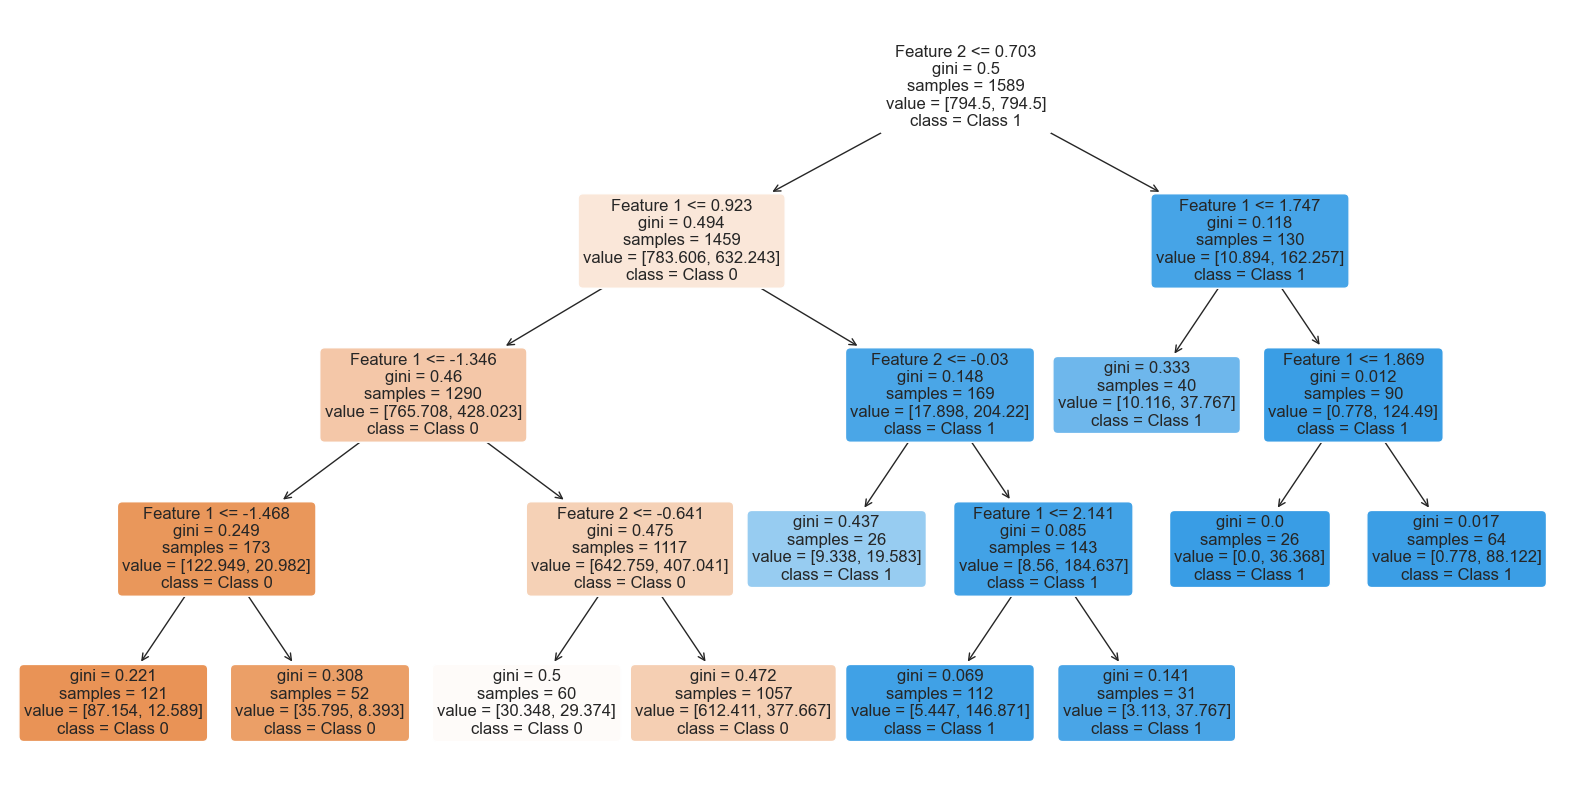

In [79]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_decision_tree_model,
    filled=True,
    feature_names=["Feature 1", "Feature 2"],
    class_names=["Class 0", "Class 1"],
    rounded=True,
);

We plotted the decision tree, since we performed feature reduction, there's not really much to analyze as we performed feature reduction, and now it is impossible to tell how an exact feature before PCA has impacted the decisions of a decision tree.

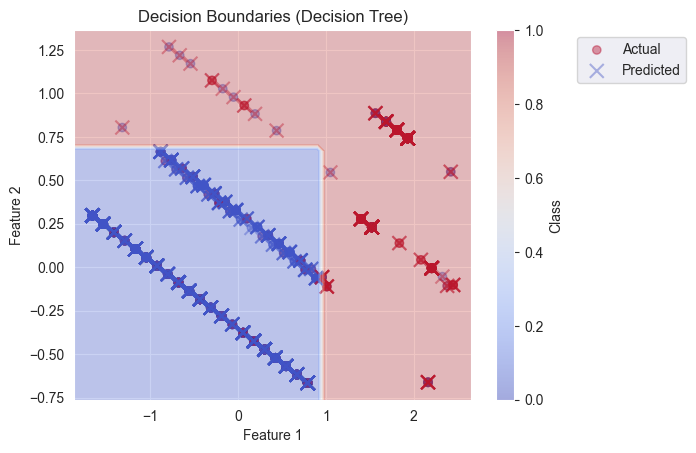

In [80]:
scatter_actual = plt.scatter(
    x_train_transformed[:, 0],
    x_train_transformed[:, 1],
    c=y_train,
    marker="o",
    label="Actual",
    cmap="coolwarm",
    alpha=0.4,
)
scatter_predicted = plt.scatter(
    x_train_transformed[:, 0],
    x_train_transformed[:, 1],
    c=decision_tree_predictions,
    marker="x",
    label="Predicted",
    cmap="coolwarm",
    alpha=0.4,
    s=100,
)
cbar_actual = plt.colorbar(scatter_actual)
cbar_actual.set_label("Class")
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
)
Z = best_decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
plt.title("Decision Boundaries (Decision Tree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(bbox_to_anchor=(1.25, 1), loc="upper left");

We can see that it pretty much drew a box around what is most likely the highest density of class '0', classifying every instance in the box as '0'.

In [81]:
num_folds = 5
cv = KFold(n_splits=num_folds, shuffle=True, random_state=1)
scores = cross_val_score(
    best_decision_tree_model, x_train_transformed, y_train, cv=cv, scoring="recall"
)
for fold, recall in enumerate(scores, start=1):
    print(f"Fold {fold}: Recall = {recall:.2f}")

print(f"\nMean Recall: {np.mean(scores):.2f}")
print(f"Standard Deviation: {np.std(scores):.2f}")

Fold 1: Recall = 0.47
Fold 2: Recall = 0.47
Fold 3: Recall = 0.46
Fold 4: Recall = 0.52
Fold 5: Recall = 0.47

Mean Recall: 0.48
Standard Deviation: 0.02


In the end we're left with mean recall of 0.48 and rather small standard deviation of 0.02.
## Random Forests

              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1021
           1       0.85      0.49      0.63       568

    accuracy                           0.79      1589
   macro avg       0.81      0.72      0.74      1589
weighted avg       0.80      0.79      0.77      1589



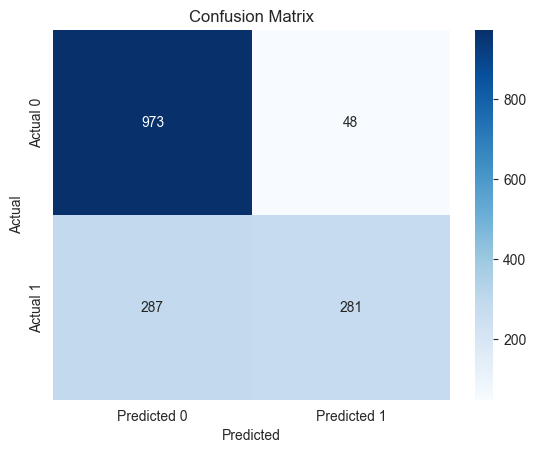

In [82]:
random_forest_model = RandomForestClassifier(
    n_estimators=100, class_weight="balanced", random_state=1
)
random_forest_model.fit(x_train_transformed, y_train)
random_forest_predictions = random_forest_model.predict(x_train_transformed)
random_forest_cm = confusion_matrix(y_train, random_forest_predictions)
random_forest_report = classification_report(y_train, random_forest_predictions)
sns.heatmap(
    random_forest_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(random_forest_report)

Random forests generally work by training a bunch of decision trees on parts of the training data and then merges their predictions to hopefully get a more accurate and stable prediction. Once again, as other models it tends to over-predict class 0.

RandomForestClassifier(class_weight='balanced', max_depth=16,
                       min_samples_leaf=2, min_samples_split=5, random_state=1)
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1021
           1       0.85      0.49      0.63       568

    accuracy                           0.79      1589
   macro avg       0.81      0.72      0.74      1589
weighted avg       0.80      0.79      0.77      1589



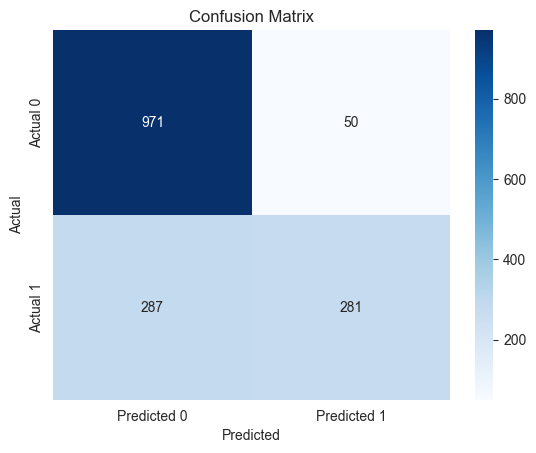

In [83]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [4, 16],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 5, 10],
    "max_features": ["sqrt", "log2"],
}
grid_search = GridSearchCV(
    estimator=random_forest_model, param_grid=param_grid, cv=5, scoring="recall"
)
grid_search.fit(x_train_transformed, y_train)
best_random_forest_model = grid_search.best_estimator_
random_forest_predictions = best_random_forest_model.predict(x_train_transformed)
random_forest_cm = confusion_matrix(y_train, random_forest_predictions)
sns.heatmap(
    random_forest_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(best_random_forest_model)
print(classification_report(y_train, random_forest_predictions))

Tuning random forests' hyperparameters requires a lot of computational power. This random forest model performs slightly worse than the previous one. The reason why a tuned model performed very slightly worse in this case is because, we might not have allowed for parameters that were used by default in 1st random forest classification model.

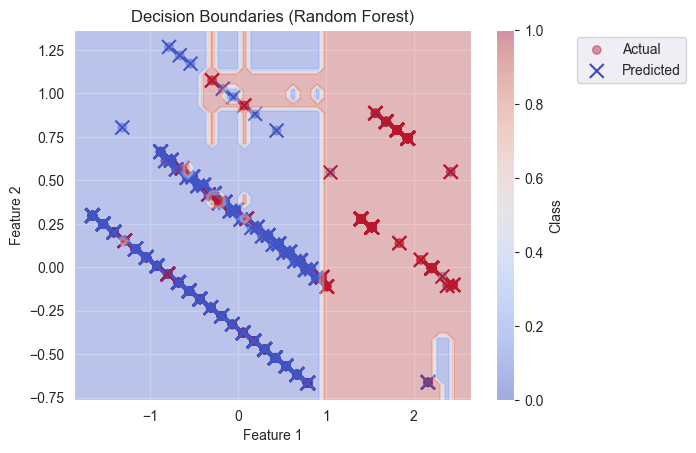

In [84]:
scatter_actual = plt.scatter(
    x_train_transformed[:, 0],
    x_train_transformed[:, 1],
    c=y_train,
    marker="o",
    label="Actual",
    cmap="coolwarm",
    alpha=0.4,
)
scatter_predicted = plt.scatter(
    x_train_transformed[:, 0],
    x_train_transformed[:, 1],
    c=random_forest_predictions,
    marker="x",
    label="Predicted",
    cmap="coolwarm",
    alpha=1,
    s=100,
)
cbar_actual = plt.colorbar(scatter_actual)
cbar_actual.set_label("Class")
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
)
Z = best_random_forest_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
plt.title("Decision Boundaries (Random Forest)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(bbox_to_anchor=(1.25, 1), loc="upper left");

It seems like the model could be over-fitting as there are specific small areas in which the model decided that it should predict class '1' among class '0'.

In [85]:
num_folds = 5
cv = KFold(n_splits=num_folds, shuffle=True, random_state=1)
scores = cross_val_score(
    best_random_forest_model, x_train_transformed, y_train, cv=cv, scoring="recall"
)
for fold, recall in enumerate(scores, start=1):
    print(f"Fold {fold}: Recall = {recall:.2f}")

print(f"\nMean Recall: {np.mean(scores):.2f}")
print(f"Standard Deviation: {np.std(scores):.2f}")

Fold 1: Recall = 0.46
Fold 2: Recall = 0.51
Fold 3: Recall = 0.49
Fold 4: Recall = 0.47
Fold 5: Recall = 0.45

Mean Recall: 0.48
Standard Deviation: 0.02


During cross validation we get average recall of 0.48 and standard deviation of 0.02, same as with decision trees.
## Voting Classifier

              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1021
           1       0.85      0.49      0.62       568

    accuracy                           0.79      1589
   macro avg       0.81      0.72      0.74      1589
weighted avg       0.80      0.79      0.77      1589



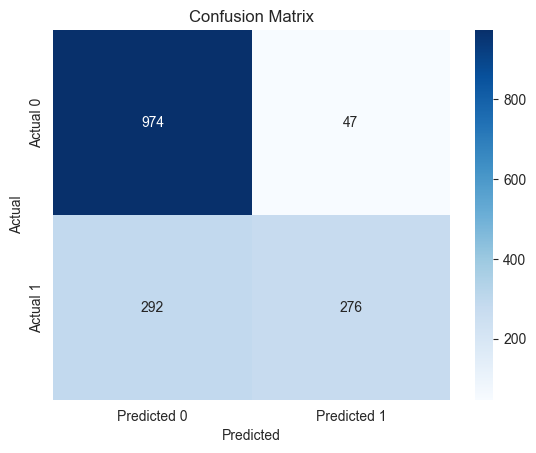

In [86]:
voting_classifier = VotingClassifier(
    estimators=[
        ("Linear_SVC", best_linear_svc_model),
        ("RBF_SVC", best_rbf_svc_model),
        ("Logistic_Regression", best_logreg_model),
        ("Random_Forests", best_random_forest_model),
    ],
    voting="soft",
)
voting_classifier.fit(x_train_transformed, y_train)
voting_classifier_predictions = voting_classifier.predict(x_train_transformed)
voting_classifier_cm = confusion_matrix(y_train, voting_classifier_predictions)
voting_classifier_report = classification_report(y_train, voting_classifier_predictions)
sns.heatmap(
    voting_classifier_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
print(voting_classifier_report)

The voting classifier does not outperform logistic regression model. This could be due to multiple reasons, the majority of models are not good with the type of data we have, our data is difficult to separate, we should apply more transformations, use more features in attempt to better separate the data, the models make the same mistakes.

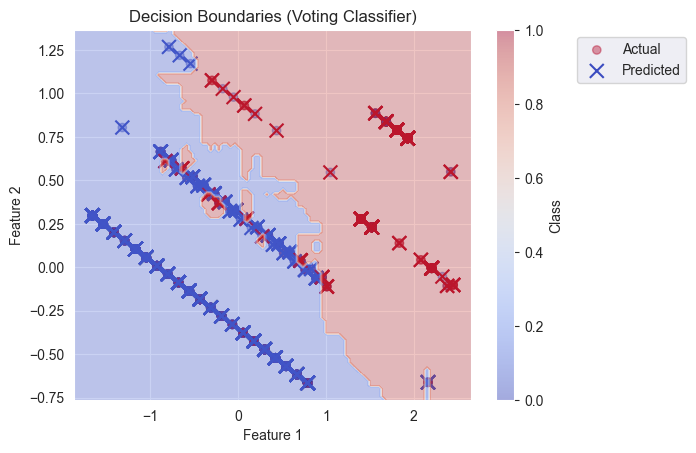

In [87]:
scatter_actual = plt.scatter(
    x_train_transformed[:, 0],
    x_train_transformed[:, 1],
    c=y_train,
    marker="o",
    label="Actual",
    cmap="coolwarm",
    alpha=0.4,
)
scatter_predicted = plt.scatter(
    x_train_transformed[:, 0],
    x_train_transformed[:, 1],
    c=voting_classifier_predictions,
    marker="x",
    label="Predicted",
    cmap="coolwarm",
    alpha=1,
    s=100,
)
cbar_actual = plt.colorbar(scatter_actual)
cbar_actual.set_label("Class")

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100)
)
Z = voting_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")

plt.title("Decision Boundaries (Voting Classifier)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(bbox_to_anchor=(1.25, 1), loc="upper left");

In [88]:
num_folds = 5
cv = KFold(n_splits=num_folds, shuffle=True, random_state=1)
scores = cross_val_score(
    voting_classifier, x_train_transformed, y_train, cv=cv, scoring="recall"
)
for fold, recall in enumerate(scores, start=1):
    print(f"Fold {fold}: Recall = {recall:.2f}")

print(f"\nMean Recall: {np.mean(scores):.2f}")
print(f"Standard Deviation: {np.std(scores):.2f}")

Fold 1: Recall = 0.45
Fold 2: Recall = 0.45
Fold 3: Recall = 0.49
Fold 4: Recall = 0.49
Fold 5: Recall = 0.46

Mean Recall: 0.47
Standard Deviation: 0.02


After cross validation we get average recall of 0.47 and standard deviation of 0.02.
# Model Selection
There are a few things that we need to consider for selecting a model. Couple are the performance of the model and how well will it generalize. In terms of performance metrics logistic regression model had higher recall of the target class and in terms of generalization I believe that the logistic regression model will also generally perform better as it doesn't have odd pockets as we've seen on the voting classifier plot, where it classifies one or two points differently from its neighbors.

In [89]:
x_test["EverTravelledAbroad"] = label_encoder.transform(x_test["EverTravelledAbroad"])
x_test["FrequentFlyer"] = label_encoder.transform(x_test["FrequentFlyer"])
x_test_transformed = annual_income_feature.transform(x_test)
to_scale = np.asarray(x_test["AnnualIncome"])
to_scale = to_scale.reshape(-1, 1)
scaled = standard_scaler.transform(to_scale)
x_test_transformed["AnnualIncome"] = scaled
x_test_transformed = column_selector.transform(x_test_transformed)
x_test_transformed = pca.transform(x_test_transformed)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       256
           1       0.60      0.61      0.60       142

    accuracy                           0.72       398
   macro avg       0.69      0.69      0.69       398
weighted avg       0.72      0.72      0.72       398



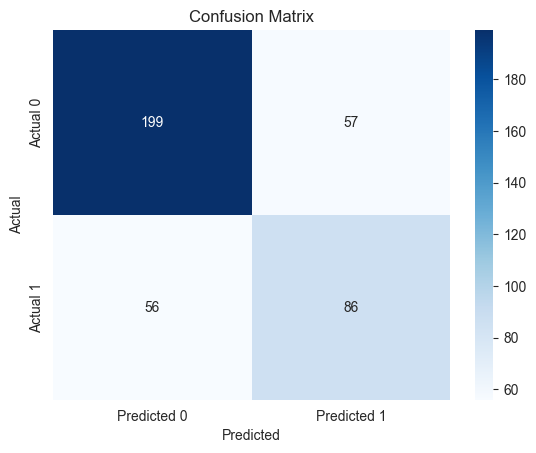

In [90]:
logreg_test_predictions = best_logreg_model.predict(x_test_transformed)
logreg_test_cm = confusion_matrix(y_test, logreg_test_predictions)
sns.heatmap(
    logreg_test_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
logreg_test_report = classification_report(y_test, logreg_test_predictions)
print(logreg_test_report)

We get recall of 0.61 for class '1' as well as precision of 0.60. These metrics have been are an improvement over what we got during training and cross validation, but it's at the cost of worse metrics for the '0' class.

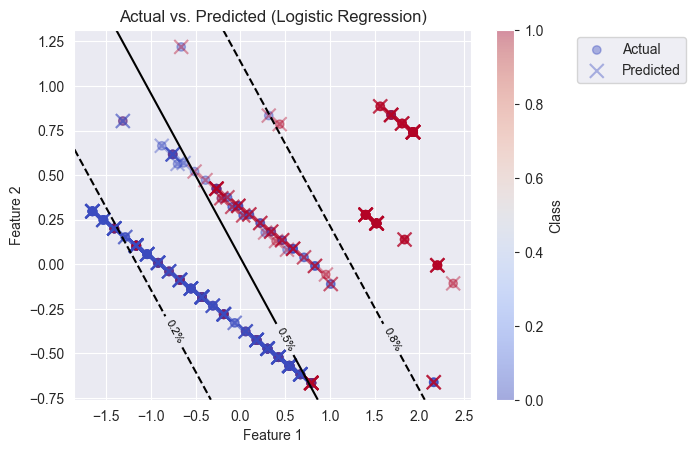

In [91]:
scatter_actual = plt.scatter(
    x_test_transformed[:, 0],
    x_test_transformed[:, 1],
    c=y_test,
    marker="o",
    label="Actual",
    cmap="coolwarm",
    alpha=0.4,
)
scatter_predicted = plt.scatter(
    x_test_transformed[:, 0],
    x_test_transformed[:, 1],
    c=logreg_test_predictions,
    marker="x",
    label="Predicted",
    cmap="coolwarm",
    alpha=0.4,
    s=100,
)
cbar_actual = plt.colorbar(scatter_actual)
cbar_actual.set_label("Class")

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50)
)
Z = best_logreg_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
probabilities = 1 / (1 + np.exp(-Z))
contour_lines = plt.contour(
    xx,
    yy,
    probabilities,
    levels=[0.25, 0.5, 0.75],
    colors="k",
    alpha=1,
    linestyles=["--", "-", "--"],
)

plt.clabel(contour_lines, inline=True, fontsize=8, colors="k", fmt="%1.1f%%")
plt.title("Actual vs. Predicted (Logistic Regression)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(bbox_to_anchor=(1.25, 1), loc="upper left");

We can observe how the model predicted and how the groups were actually distributed.
# Conclusions
We have performed EDA and statistical inference, looked for anomalies and trained our models, later testing the final one on the testing set. In the end we can conclude that:
* We looked over the dataset and did not find any null values, but did find some duplicate instance, which we cannot prove whether they're actually duplicates or not, as the features in the dataset are either binary or don't have many categories.
* We looked for outliers by plotting box plots and found none.
* We looked at how well the points are separated by numerical features and found out that most of them don't separate that well except for AnnualIncome feature. We created an extra feature based on annual income.
* We looked at the rates at which people from certain groups tend to buy or not buy travel insurance.
* We looked at whether binary features separate the classes well and found that the EverTravelledAbroad feature does tend to separate them relatively well. Also noticed that people who don't travel often and have not travelled abroad tend to not buy insurance.
* We looked at VIF and saw that there were some multi-collinearity issues and thus removed NotATraveller feature.
* We tested hypotheses whether there's significance in our features and other than ChronicDiseases and GraduateOrNot features are indeed significant.
* We trained 6 models in total and due to logistic regressions models' performance and generalization capabilities we tested it against the test set.
# Improvements for the future
* Better formulation of the problem would have allowed us to make a better decision when it came to training the models: should we emphasise the class '1', the people who bought the insurance more often and assign it more aggressive weight, or should we keep it balanced as we did. Knowing, what's more important to us, making less mistakes, or having more people buy travel insurance, would've helped in this decision. Also having more information on the economy part of the problem, would allow us to tell whether we would want to use the final logistic regression model, however, I believe, that such cost-benefit analysis is slightly out of scope for this project.
* More extensive statistical inference part. We've only used chi-square and Mann-Whitney U tests to test for our features' significance.
* Better feature engineering or transformations to the existing data. Some better features that would allow us to better separate the two classes or achieving similar result by transforming the independent features.
* Trying out training the models with more features. We've used only 4 features to train our models, perhaps using more would've resulted in better separation of our classes which would have possibly lead to better recall and other metrics.
* Use of pipelines to handle transformations and flow of data.
* In some cases the code cells tended to be very similar with minor differences, functions could've possibly been used instead.